This notebook contains the full evaluation pipeline for a trained model

## Setup

In [3]:
# file_name = '../Chandra_data/large_eventfiles_filtered_lifetime28800_randomshift.pkl'
# model_name = '../experiments/testthin_large_filter_TVseparate_E3_decoder_lamTV10_lamlatent1_4latents_512hidden_5blocks_B16'
# checkpoint = 'model_3600epochs.ckpt'

# This is the final checkpoint used for generating plots in the paper
file_name = '../Chandra_data/large_eventfiles_lifetime28800_randomshift.pkl'
model_name = '../experiments/testthin_finetune2_large_TVseparate_E3_decoder_lamTV10_lamlatent1_8latents_512hidden_5blocks_B16'
checkpoint = 'model_600epochs_lr1e-05.ckpt'

title_size = 26
label_size = 22
tick_size = 20


from utils import *
from dataset import *
from autodecoder import *
import pickle
import json
class DotDict:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                value = DotDict(value)
            self.__dict__[key] = value
device = "cuda"
B = 64
num_freqs = 12

# Load data
with open(file_name, 'rb') as file: 
    data_lst = pickle.load(file)
data = RealEventsDataset(data_lst, t_scale=28800)
test_loader = DataLoader(data, batch_size=B, collate_fn=padding_collate_fn)

## Optional: load the model and compute latents

In [13]:
# Load model
encoding = PositionalEncoding(num_freqs=num_freqs,include_input=True)
with open(f'{model_name}/arguments.json', 'r') as file:
    opt = json.load(file)
opt = DotDict(opt)
model = AutoEncoder.load_from_checkpoint(f'{model_name}/{checkpoint}', opt=opt, encoding=encoding, latent_num=len(data))
model.to(device);

outputs = []
for idx, batch in enumerate(test_loader):
    temp = idx * B
    if temp % 4096 == 0:
        print(temp)
    batch = todevice(batch, device)
    batch = model(batch)
    outputs.append(todevice(batch,'cpu'))

def output_collate_fn(outputs):
    '''
    Outputs is a list of dic
    '''
    output = {}
    for key in outputs[0].keys():
        if key in ['latent','T','num_events','class','hard_hm','hard_hs','hard_ms','var_prob_b','var_prob_s','var_prob_m','var_prob_h','var_index_b']:
            output[key] = torch.cat([o[key] for o in outputs], dim=0)
        # elif key == 'class':
        #     output[key] = sum([o[key] for o in outputs],[])
        else:
            output[key] = [o[key] for o in outputs]
    return output

collated_outputs = output_collate_fn(outputs)
collated_outputs['num_events_per'] = collated_outputs['num_events'] / collated_outputs['T']

# Save it
file_name = f'{model_name}/latent_latest.pkl'
with open(file_name, 'wb') as file:  # Note the 'wb' mode for writing bytes
    pickle.dump(collated_outputs, file)

0
Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 5818
Input similarities computed in 1.47 seconds (sparsity = 0.024895)!
Learning embedding...
Iteration 50: error is 89.444085 (50 iterations in 3.55 seconds)
Iteration 100: error is 85.101570 (50 iterations in 3.05 seconds)
Iteration 150: error is 84.825955 (50 iterations in 2.96 seconds)
Iteration 200: error is 84.824880 (50 iterations in 3.01 seconds)
Iteration 250: error is 4.583781 (50 iterations in 2.98 seconds)
Iteration 300: error is 2.796305 (50 iterations in 2.81 seconds)
Iteration 350: error is 2.492942 (50 iterations in 2.86 seconds)
Iteration 400: error is 2.325463 (50 iterations in 2.92 seconds)
Iteration 450: error is 2.220922 (50 iterations in 2.98 seconds)
Iteration 500: error is 2.148892 (50 iterations in 3.01 seconds)
Iteration 550: error is 2.096945 (50 iterations in 3.05 seconds)
Iteration 600: error i

## Otherwise: directly load latents

In [4]:
file_name = f'{model_name}/latent_latest.pkl'
with open(file_name, 'rb') as file: 
    collated_outputs = pickle.load(file)
data = {}
for key in ['latent', 'hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h']:
    data[key] = collated_outputs[key].numpy()

## Find indices

In [5]:
# import json

# # Open and read the JSON file
# with open('../Chandra_data/bonafide_others.json', 'r') as file:
#     source_dict = json.load(file)
    
# id_dict = {}
# for key in source_dict:
#     inds = []
#     source_lst = source_dict[key]
#     for target in source_lst:
#         N = 14891
#         for i in range(N):
#             b = i // B
#             bb = i % B
#             if target in collated_outputs['id'][b][bb]:
#                 inds.append(i)
#     id_dict[key] = inds
# print(id_dict)

target = '11029'
N = 109656
inds = []
for i in range(N):
    b = i // B
    bb = i % B
    if target in collated_outputs['id'][b][bb]:
        print(i, collated_outputs['id'][b][bb])
        inds.append(i)
print(inds)
print(len(inds))

# N = 14891
# i = 77 * B
# b = i // B
# bb = i % B
# print(collated_outputs['id'][b][bb])

## For an ind, find the obs id
# total_index = 304
# batch_index = total_index // B
# index = total_index % B
# collated_outputs['id'][batch_index][index]

61197 11029_143_1
86044 11029_421_1
86163 11029_428_1
86346 11029_434_1
90030 11029_549_1
[61197, 86044, 86163, 86346, 90030]
5


## Reconstruction Plots

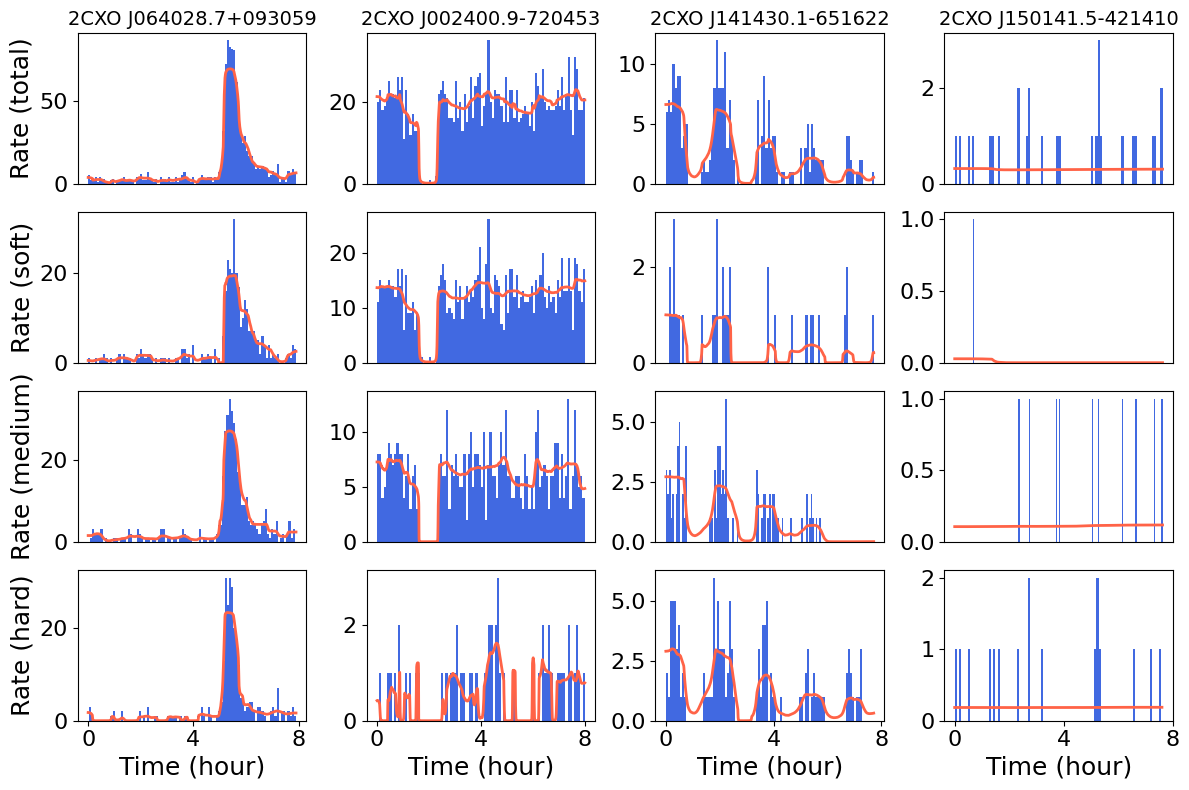

In [5]:
# batch_indices = [1,41,44,77]  # For filtered
# indices = [i * B for i in batch_indices]

indices = [88128, 44864, 59781, 304] # For large, representative sources
# indices = [12324,12325,12494,12645] # For large filtered, variable tSNE cluster
# indices = [86346, 90030, 86044, 86163] # For large, some spectral variable sources
# indices = [554,2445,3407,4219]
# 1920: two thin dips
# indices = [107778, 107779, 107782, 107794]  # Just for checking
save_name1 = f'{model_name}/reconstruction_wnames.pdf'
save_name2 = f'{model_name}/reconstruction_wnames.png'
# titles = ['14368_489: flare','16527_79: dip','12823_136: periodic','13739_3: flat?']
# titles = ['flare','dip','periodic','flat?']
titles = [
    "2CXO J064028.7+093059",
    "2CXO J002400.9-720453",
    "2CXO J141430.1-651622",
    "2CXO J150141.5-421410",
]

def plot_recon_grid_poster(collated_outputs,
                    indices,
                   title_size=26,
                   label_size=18,
                legend_size=16,
                   tick_size=16,
                    figsize=(12,10),
                   nbins=96,
                   t_scale=28800,
                    B=64,
                   ):
    k = len(indices)
    

    fig, axes = plt.subplots(k, k, figsize=figsize)
    for i, total_index in enumerate(indices):

        batch_index = total_index // B
        index = total_index % B

        mask = collated_outputs['mask'][batch_index][index]
        unfiltered_times = collated_outputs['event_list'][batch_index][index,mask,:] * t_scale / 3600
        total_mask = collated_outputs['total_mask'][batch_index][index]
        total_times = collated_outputs['total_list'][batch_index][index,total_mask,0] * t_scale / 3600
        rates = collated_outputs['total_rates'][batch_index][index,total_mask] / nbins

        T = collated_outputs['T'][total_index] * t_scale
        
        # Total rate
        axes[0,i].hist(unfiltered_times[:,0], bins = nbins, color='royalblue', label='Actual counts')
        axes[0,i].plot(total_times, torch.sum(rates,dim=-1), color='tomato', label='Fitted rate',linewidth=2)
        axes[0,i].tick_params(axis='both', which='major', labelsize=tick_size)
        axes[0,i].set_xticks([])
        # Rate for each bin
        for j in range(3):
            E_mask = (unfiltered_times[:,j+1]>0)
            times = unfiltered_times[E_mask,0]
            axes[j+1,i].hist(times, bins = nbins, color='royalblue', label='Actual counts')
            axes[j+1,i].plot(total_times, rates[:,j], label='Fitted rate', color='tomato', linewidth=2)
            axes[j+1,i].tick_params(axis='both', which='major', labelsize=tick_size)
            if j != 2:
                axes[j+1,i].set_xticks([])
            else:
                axes[j+1,i].set_xticks([0,4,8])
        if i == 2 and j == 1:
            axes[j,i].legend(loc='upper left', fontsize=legend_size)
        if i == 0:
            axes[0,i].set_ylabel('Rate (total)', fontsize=label_size)
            axes[1,i].set_ylabel('Rate (soft)', fontsize=label_size)
            axes[2,i].set_ylabel('Rate (medium)', fontsize=label_size)
            axes[3,i].set_ylabel('Rate (hard)', fontsize=label_size)
        axes[0,i].set_title(titles[i], fontsize=14)
        axes[3,i].set_xlabel('Time (hour)', fontsize=label_size)
    plt.tight_layout()

    
plot_recon_grid_poster(collated_outputs, indices, figsize=(12,8))
# plt.savefig(save_name1)
# plt.savefig(save_name2)

##### One time thing: only show event files

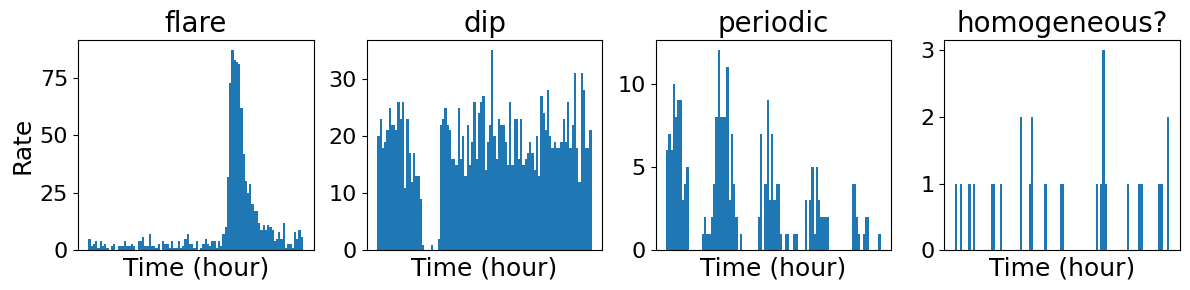

In [3]:
indices = [88128, 44864, 59781, 304] # For large
# 1920: two thin dips
# indices = [59780, 59781, 59783, 59799]
save_name1 = f'{model_name}/raw_events.pdf'
save_name2 = f'{model_name}/raw_events.png'
titles = ['flare','dip','periodic','homogeneous?']

def plot_recon_grid_poster(collated_outputs,
                    indices,
                   title_size=26,
                   label_size=18,
                legend_size=16,
                   tick_size=16,
                    figsize=(12,3),
                   nbins=96,
                   t_scale=28800,
                    B=64,
                   ):
    k = len(indices)
    

    fig, axes = plt.subplots(1, k, figsize=figsize)
    for i, total_index in enumerate(indices):

        batch_index = total_index // B
        index = total_index % B

        mask = collated_outputs['mask'][batch_index][index]
        unfiltered_times = collated_outputs['event_list'][batch_index][index,mask,:] * t_scale / 3600
        
        # Total rate
        axes[i].hist(unfiltered_times[:,0], bins = nbins)
        axes[i].tick_params(axis='both', which='major', labelsize=tick_size)
        axes[i].set_xticks([])
        if i == 0:
            axes[0].set_ylabel('Rate', fontsize=label_size)
        axes[i].set_title(titles[i], fontsize=20)
        axes[i].set_xlabel('Time (hour)', fontsize=label_size)
    plt.tight_layout()

    
plot_recon_grid_poster(collated_outputs, indices, figsize=(12,3))
plt.savefig(save_name1)
plt.savefig(save_name2)

# t_scale=28800
# nbins=96
# B=64
# total_index = 88128 # For large
# save_name1 = f'{model_name}/flare_event.pdf'
# save_name2 = f'{model_name}/flare_event.png'
# titles = ['non-varying']


    
# figsize=(4,3)
# fig, axes = plt.subplots(figsize=figsize)

# batch_index = total_index // B
# index = total_index % B

# mask = collated_outputs['mask'][batch_index][index]
# unfiltered_times = collated_outputs['event_list'][batch_index][index,mask,:] * t_scale / 3600

# # Total rate
# axes.hist(unfiltered_times[:,0], bins = nbins)
# axes.tick_params(axis='both', which='major', labelsize=14)
# axes.set_xticks([])
# axes.set_ylabel('Rate', fontsize=16)
# axes.set_xlabel('Time (hour)', fontsize=16)
# plt.tight_layout()

# plt.savefig(save_name1)
# plt.savefig(save_name2)

## Visualizing latent space

### PCA

In [11]:
metrics = ['hard_hm','hard_ms','hard_hs']
# metrics = ['var_index_b','var_prob_b','var_prob_h']
save_name1 = f'{model_name}/PCA.pdf'
save_name2 = f'{model_name}/PCA.png'

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z = collated_outputs['latent']
embedding = pca.fit_transform(z)

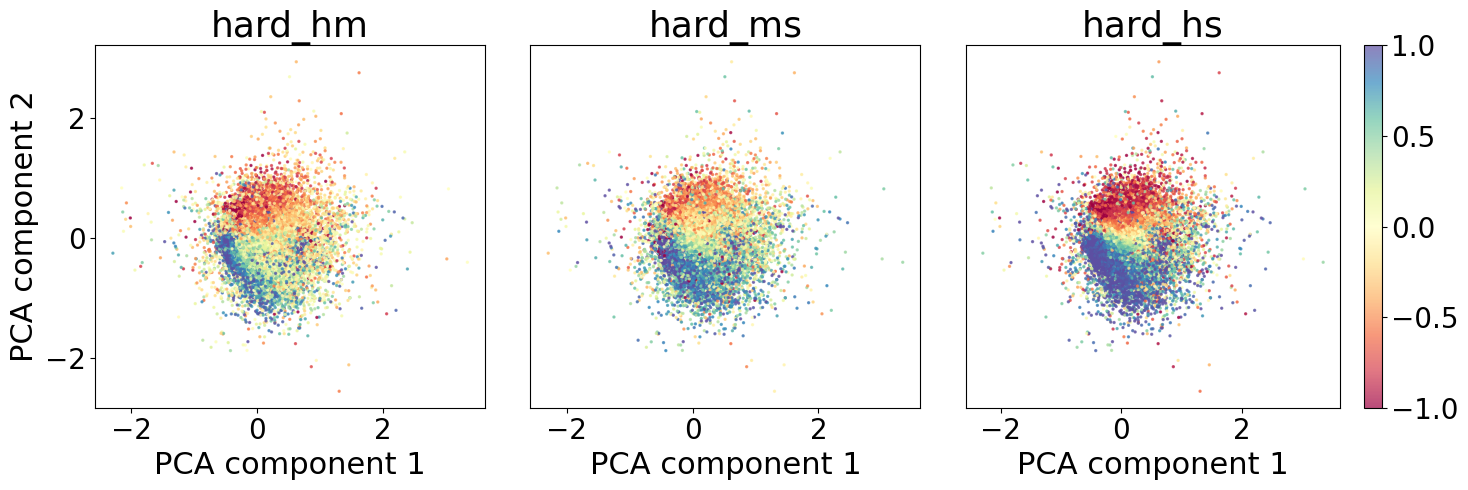

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.2]})
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=collated_outputs[metric], cmap='Spectral', alpha=0.7, 
                marker='o',s=2, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]), rasterized=True)
    ax.set_xlabel('PCA component 1',size=label_size)
    if i == 0:
        ax.set_ylabel('PCA component 2',size=label_size)
    else:
        ax.set_yticks([])
    if i == 2:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.savefig(save_name1)
plt.savefig(save_name2)

### Latent dimensions

In [ ]:
metrics = ['hard_hm','hard_ms','hard_hs']
# metrics = ['var_index_b','var_prob_b','var_prob_h']
save_name = f'{model_name}/coordinates.png'

fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.2]})
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(z[:, 0], z[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
                marker='o',s=2, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
    ax.set_xlabel('Latent Dimension 1',size=label_size)
    if i == 0:
        ax.set_ylabel('Latent Dimension 2',size=label_size)
    if i == 2:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.savefig(save_name)

### tsne

In [3]:
# metrics = ['hard_hm','hard_ms','hard_hs']
metrics = ['var_prob_m','var_prob_b','var_index_b']
save_name1 = f'{model_name}/tSNE.pdf'
save_name2 = f'{model_name}/tSNE.png'

from bhtsne import tsne
z = collated_outputs['latent']
data_nd_tsne = tsne(z.numpy().astype(np.float64))

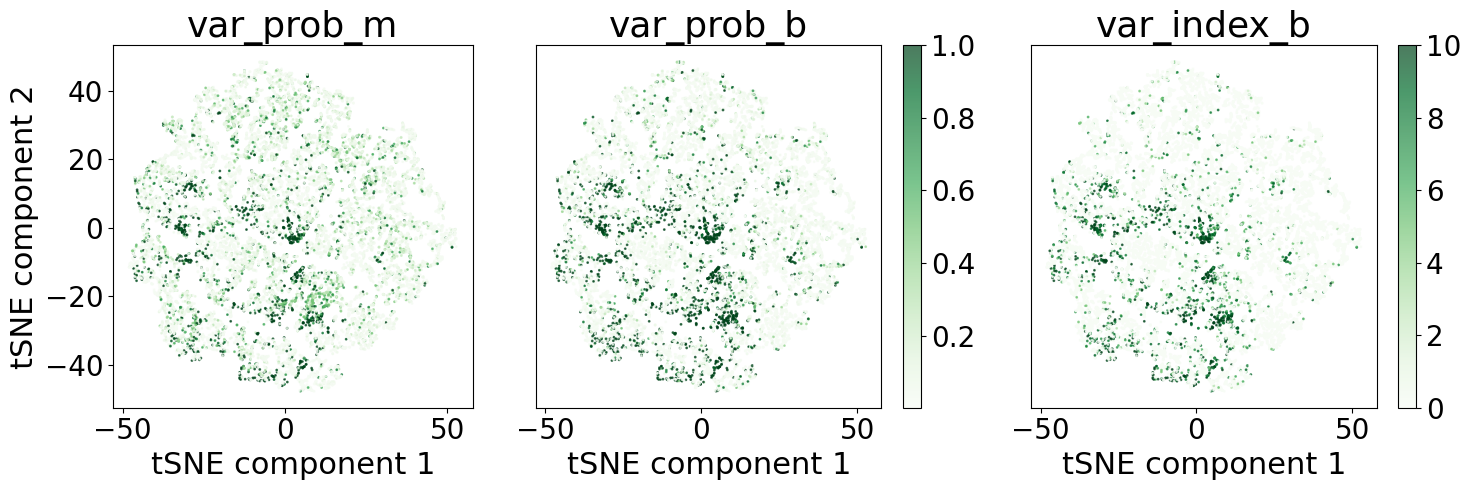

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.2, 1.2]})
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(data_nd_tsne[:, 0], data_nd_tsne[:, 1], c=collated_outputs[metric], cmap='Greens', alpha=0.7, 
            marker='o',s=1, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
    ax.set_xlabel('tSNE component 1',size=label_size)
    if i == 0:
        ax.set_ylabel('tSNE component 2',size=label_size)
    else:
        ax.set_yticks([])
    if i >0:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.savefig(save_name1)
plt.savefig(save_name2)

#### One time thing: do plot annotation with some id in mind

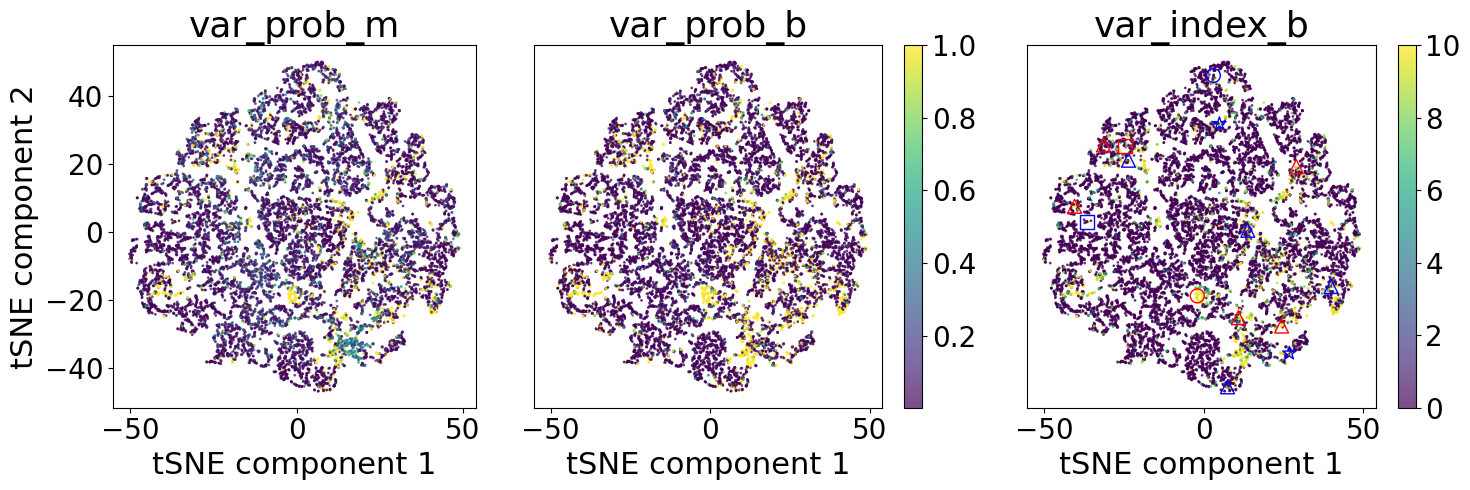

In [26]:
metrics = ['var_prob_m','var_prob_b','var_index_b']
save_name1 = f'{model_name}/tSNE.pdf'
save_name2 = f'{model_name}/tSNE.png'

# Find the index
# index = np.argmax(collated_outputs['var_prob_b'])
# n = len(collated_outputs['var_prob_b'])
# for i in range(n):
#     if data_nd_tsne[i,0] > -30 and  data_nd_tsne[i,0] < -20 and  data_nd_tsne[i,1] > -40 and  data_nd_tsne[i,1] < -30 and collated_outputs['var_prob_b'][i] > 0.99:
#         print(i)
        
index = 3407


fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.2, 1.2]})
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(data_nd_tsne[:, 0], data_nd_tsne[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
            marker='o',s=1, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
    ax.set_xlabel('tSNE component 1',size=label_size)
    if i == 0:
        ax.set_ylabel('tSNE component 2',size=label_size)
    else:
        ax.set_yticks([])
    if i >0:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
        
    # Annotation
    shapes = ['o','^','s','*']
    if i == 2:
        with open('../Chandra_data/bonafide_dips_ids.json', 'r') as file:
            id_dict = json.load(file)
            for shape_id, key in enumerate(id_dict.keys()):
                temp_ids = id_dict[key]
                ax.scatter(data_nd_tsne[temp_ids, 0], data_nd_tsne[temp_ids, 1], facecolor='none', edgecolor='blue', marker=shapes[shape_id], s=100)
        with open('../Chandra_data/bonafide_flares_ids.json', 'r') as file:
            id_dict = json.load(file)
            for shape_id, key in enumerate(id_dict.keys()):
                temp_ids = id_dict[key]
                ax.scatter(data_nd_tsne[temp_ids, 0], data_nd_tsne[temp_ids, 1], facecolor='none', edgecolor='red', marker=shapes[shape_id], s=100)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
# plt.savefig(save_name1)
# plt.savefig(save_name2)

## Regression and Classification

### Regression on continuous values

In [17]:
y_label = 'hard_ms'
# y_label = 'var_index_b'
random_state = 2020


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

X = data['latent']
y = data[y_label]
valid_ind = ~np.isnan(y)
X = X[valid_ind,:]
y = y[valid_ind]

if y_label in ['var_prob_s','var_prob_h','var_prob_m']:
    valid_ind = (y<1)
    X = X[valid_ind,:]
    y = y[valid_ind]
    y = np.log(y/(1-y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


model = RandomForestRegressor(n_estimators=100, random_state=random_state, verbose=2)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"MSE: {mse:.3f}")
print(f"R-squared: {r2:.3f}")

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R-squared: {r2:.3f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


MSE: 0.003
R-squared: 0.982
MSE: 0.023
R-squared: 0.873


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


### Classification on discrete values

In [6]:
y_label = 'var_index_b'
smote = True


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X = data['latent']
y = data[y_label]
valid_ind = ~np.isnan(y)
X = X[valid_ind,:]
y = y[valid_ind]

if y_label in ['var_index_b','var_index_h','var_index_m','var_index_s']:
    y = 1 * (y >= 6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=2)
if smote:
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
else:
    X_train_resampled, y_train_resampled = X_train, y_train
    
model.fit(X_train_resampled, y_train_resampled)


y_train_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
classification_rep = classification_report(y_train, y_train_pred)

print(f"Model accuracy: {accuracy:.3f}")
print("Classification report:")
print(classification_rep)

# Predict the labels of the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Model accuracy: {accuracy:.3f}")
print("Classification report:")
print(classification_rep)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Model accuracy: 1.000
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82956
           1       1.00      1.00      1.00      4768

    accuracy                           1.00     87724
   macro avg       1.00      1.00      1.00     87724
weighted avg       1.00      1.00      1.00     87724

Model accuracy: 0.917
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     20756
           1       0.28      0.34      0.30      1176

    accuracy                           0.92     21932
   macro avg       0.62      0.64      0.63     21932
weighted avg       0.93      0.92      0.92     21932



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


### Classification on source type

In [52]:
# Cross match data
true_classes_df = pd.read_csv('../Chandra_data/TD.csv')
raw_property_df = pd.read_csv('../Chandra_data/properties-Full.csv')
raw_property_df = raw_property_df.drop_duplicates(subset=['name', 'obsid','region_id'])

matched_df = pd.merge(true_classes_df.rename(columns={'CSCv2_name': 'name'}), raw_property_df, on='name', how='inner')
matched_df = matched_df[['True_Class','region_id','obsid']]
matched_df['id'] = matched_df['obsid'].astype(str) + "_" + matched_df['region_id'].astype(str)
matched_d = {}
for _, row in matched_df.iterrows():
    matched_d[row['id']] = row['True_Class']
print(f'{len(matched_d.keys())} sources have known class types')


good_data = {'True_Class':[]}
temp_ids = collated_outputs['id']
collated_ids = [e for sublist in temp_ids for e in sublist]

final_matched_inds = []
for i,ind in enumerate(collated_ids):
    if ind[-1] == '1' and ind[:-2] in matched_d.keys():
        final_matched_inds.append(i)
        good_data['True_Class'].append(matched_d[ind[:-2]])
for key in ['latent', 'hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h']:
    if key == 'latent':
        good_data[key] = collated_outputs[key][final_matched_inds,:]
    else:
        good_data[key] = collated_outputs[key][final_matched_inds]

class_matching_d = {'AGN':0, 'CV':1, 'HM-STAR':2, 'HMXB':3, 'LM-STAR':4, 'LMXB':5, 'NS':6, 'YSO':7}
good_data['numbered_class'] = [class_matching_d[k] for k in good_data['True_Class']]


print(f'amone those, {len(final_matched_inds)} are actually in our reconstructed ones')

4915 sources have known class types
amone those, 2325 are actually in our reconstructed ones


In [55]:
y_label = 'numbered_class'
smote = True
# random_state = 42

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE


# Prepare your data: separate features (X) and the target variable (y)
X = good_data['latent']
Z_labels = ['hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h']
# Z_labels = ['hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h']
Z = np.zeros((X.shape[0], len(Z_labels)+X.shape[1]))
for zi, label in enumerate(Z_labels):
    Z[:,zi] = good_data[label]
# Z[:,-X.shape[1]:] = X
Z = Z[:,:len(Z_labels)]
print(Z.shape)
y = good_data[y_label]
y = np.array(y)

# Optional: only do AGNs and YSOs
# valid_indices = (y == 0) | (y == 7)
# y = y[valid_indices]
# X = X[valid_indices,:]
# Z = Z[valid_indices,:]


################# Do classification on X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

if smote:
    smote = SMOTE(random_state=random_state, k_neighbors=1)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
else:
    X_train_resampled, y_train_resampled = X_train, y_train
    
model = RandomForestClassifier(n_estimators=100, random_state=random_state, verbose=2)
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate on the training data
y_train_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
classification_rep_train = classification_report(y_train, y_train_pred)

print(f"Training data model accuracy: {accuracy_train:.3f}")
print("Training data classification report:")
print(classification_rep_train)

# Predict the labels of the test set
y_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Test data model accuracy: {accuracy_test:.3f}")
print("Test data classification report:")
print(classification_rep_test)

################ Do classification on Z
# Filter out NaNs
nan_mask = np.isnan(Z).any(axis=1)  # True if any element in the row of X is NaN

# Filter out rows with NaN
Z = Z[~nan_mask]
y = y[~nan_mask]


Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=random_state)

if smote:
    smote = SMOTE(random_state=random_state, k_neighbors=1)
    Z_train_resampled, y_train_resampled = smote.fit_resample(Z_train, y_train)
else:
    Z_train_resampled, y_train_resampled = Z_train, y_train
    
model = RandomForestClassifier(n_estimators=100, random_state=random_state, verbose=2)
model.fit(Z_train_resampled, y_train_resampled)

# Predict and evaluate on the training data
y_train_pred = model.predict(Z_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
classification_rep_train = classification_report(y_train, y_train_pred)

print(f"Training data model accuracy: {accuracy_train:.3f}")
print("Training data classification report:")
print(classification_rep_train)

# Predict the labels of the test set
y_pred = model.predict(Z_test)
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Test data model accuracy: {accuracy_test:.3f}")
print("Test data classification report:")
print(classification_rep_test)

(2325, 8)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefined

Training data model accuracy: 1.000
Training data classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       686
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00       117
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        88
           7       1.00      1.00      1.00       869

    accuracy                           1.00      1860
   macro avg       1.00      1.00      1.00      1860
weighted avg       1.00      1.00      1.00      1860

Test data model accuracy: 0.544
Test data classification report:
              precision    recall  f1-score   support

           0       0.59      0.62      0.61       175
           1       0.00      0.00      0.00         2
           2       0.17      0.08      0.11     

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefined

In [67]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# embedding = pca.fit_transform(X)
# save_name1 = f'{model_name}/PCA_class.pdf'
# save_name2 = f'{model_name}/PCA_class.png'

# fig = plt.figure(figsize=(6,5))
# plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis', alpha=0.7, 
#             marker='o',s=1, vmin=min(y), vmax=max(y))
# plt.xlabel('PCA component 1', size=label_size)
# plt.ylabel('PCA component 2', size=label_size)
# plt.rc('xtick', labelsize=tick_size)
# plt.rc('ytick', labelsize=tick_size)
# plt.colorbar()

# plt.savefig(save_name1)
# plt.savefig(save_name2)

from bhtsne import tsne
embedding = tsne(X.numpy().astype(np.float64))

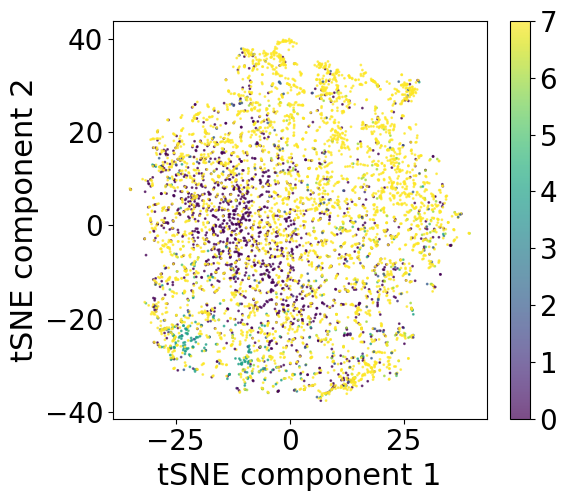

In [68]:
save_name1 = f'{model_name}/tSNE_class.pdf'
save_name2 = f'{model_name}/tSNE_class.png'

fig = plt.figure(figsize=(6,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis', alpha=0.7, 
            marker='o',s=1, vmin=min(y), vmax=max(y))
plt.xlabel('tSNE component 1', size=label_size)
plt.ylabel('tSNE component 2', size=label_size)
plt.rc('xtick', labelsize=tick_size)
plt.rc('ytick', labelsize=tick_size)
plt.colorbar()
plt.tight_layout()
plt.savefig(save_name1)
plt.savefig(save_name2)

## Anomaly detection

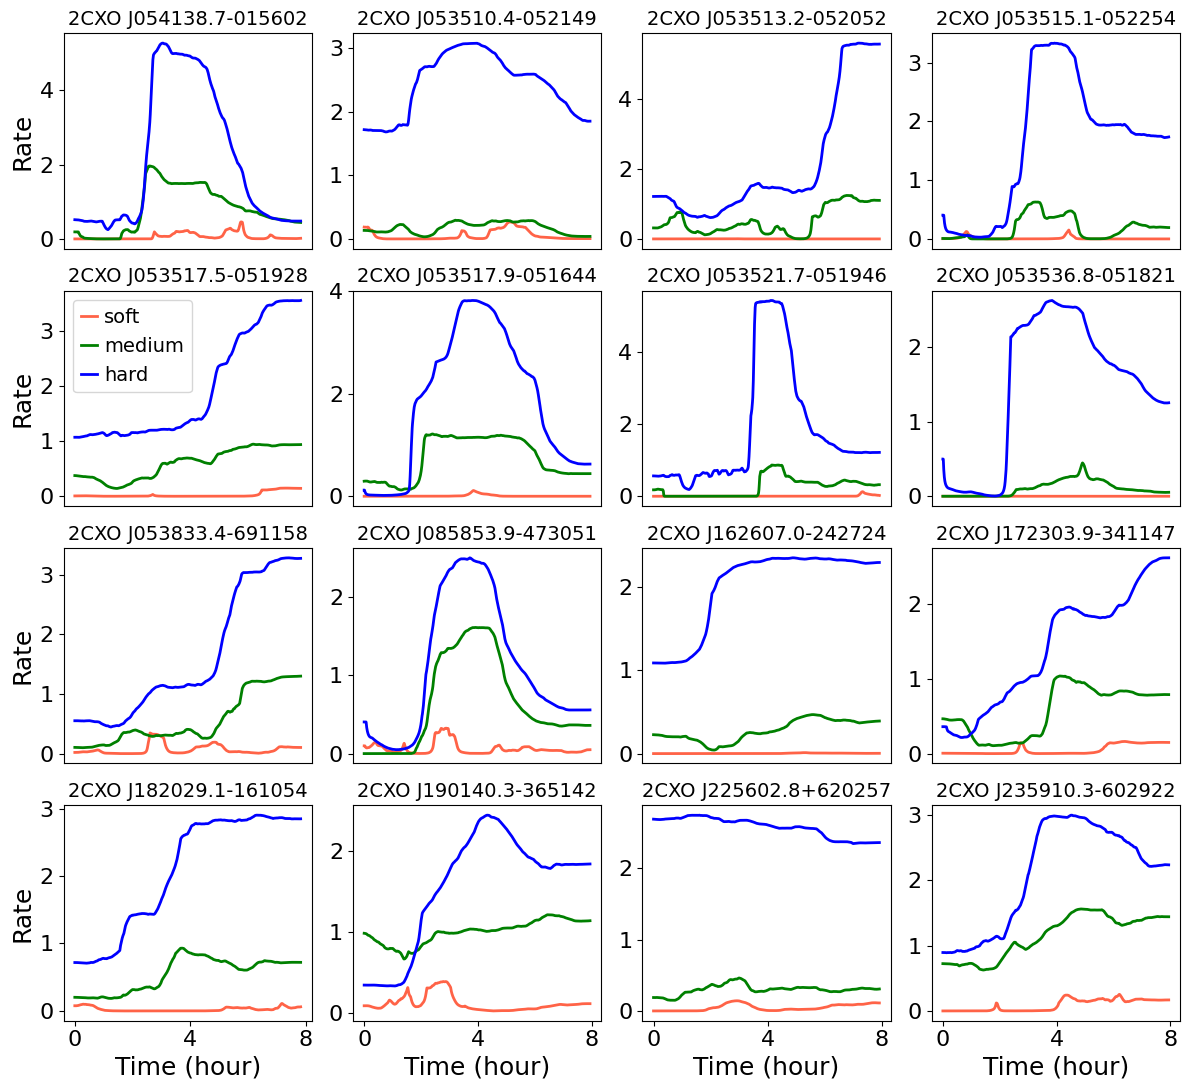

In [11]:
title_size=26
label_size=18
legend_size=14
tick_size=16
figsize=(12,11)
nbins=96
t_scale=28800
B=64

# seed_index = 107779
# title = "Other Flares"
# save_name1 = f'{model_name}/find_anomaly_{seed_index}.pdf'
# save_name2 = f'{model_name}/find_anomaly_{seed_index}.png'

save_name1 = f'{model_name}/anomaly_class_hard_flare_small_wnames.pdf'
save_name2 = f'{model_name}/anomaly_class_hard_flare_small_wnames.png'


# seed_index = 88128 # large dataset, a large and short flare
seed_index = 3407 # filtered dataset, a wide and relatively low count flare, mainly at hard energy band
# corresponding names for those neighbors. Since the latent dataset didn't include it, we searched it elsewhere
# directly copy them here.
names = [
    "2CXO J054138.7-015602",
    "2CXO J053510.4-052149",
    "2CXO J053513.2-052052",
    "2CXO J053515.1-052254",
    "2CXO J053517.5-051928",
    "2CXO J053517.9-051644",
    "2CXO J053521.7-051946",
    "2CXO J053536.8-051821",
    "2CXO J053833.4-691158",
    "2CXO J085853.9-473051",
    "2CXO J162607.0-242724",
    "2CXO J172303.9-341147",
    "2CXO J182029.1-161054",
    "2CXO J190140.3-365142",
    "2CXO J225602.8+620257",
    "2CXO J235910.3-602922",
]
# seed_index = 11074 # For filtered
nrow = 4
ncol = 4

X = data['latent']
seed_latent = X[seed_index,:]
k = nrow * ncol

# Compute L2 distances
distances = np.linalg.norm(X - seed_latent, axis=1)
closest_rows_indices = np.argpartition(distances, k)[:k]
indices = closest_rows_indices[np.argsort(distances[closest_rows_indices])]

labels = ['soft','medium','hard']
colors = ['tomato','green','blue']

fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
for i, total_index in enumerate(indices):
    irow = i // ncol
    icol = i % ncol

    batch_index = total_index // B
    index = total_index % B

    mask = collated_outputs['mask'][batch_index][index]
    unfiltered_times = collated_outputs['event_list'][batch_index][index,mask,:] * t_scale / 3600
    total_mask = collated_outputs['total_mask'][batch_index][index]
    total_times = collated_outputs['total_list'][batch_index][index,total_mask,0] * t_scale / 3600
    rates = collated_outputs['total_rates'][batch_index][index,total_mask] / nbins

    # T = collated_outputs['T'][total_index] * t_scale
    T = t_scale
    
    obsreg_id = collated_outputs['id'][batch_index][index][:-2]


    # Rate for each bin
    for j in range(3):
        E_mask = (unfiltered_times[:,j+1]>0)
        times = unfiltered_times[E_mask,0]
        axes[irow,icol].plot(total_times, rates[:,j], color=colors[j], label=labels[j],linewidth=2)
        axes[irow,icol].tick_params(axis='both', which='major', labelsize=tick_size)
        
    axes[irow, icol].set_title(names[i], fontsize=14)
        
    if irow != nrow-1:
        axes[irow,icol].set_xticks([])
    else:
        axes[irow, icol].set_xticks([0,4,8])
        axes[irow,icol].set_xlabel('Time (hour)', fontsize=label_size)
    if irow==1 and icol==0:
        axes[irow,icol].legend(loc='upper left', fontsize=legend_size, handlelength=0.8, handletextpad=0.4)
    if icol == 0:
        axes[irow,icol].set_ylabel('Rate', fontsize=label_size)


# plt.suptitle(title, fontsize=title_size)
plt.tight_layout()


plt.savefig(save_name1)
plt.savefig(save_name2)